# Welcome to the Bayesian Peak Finder Tool!

### If this is your first time using the tool, please read this introduction before you do anything else. If not, and you feel confident that you know how to use the tool, you can progress to the remainder of the code. This tool is meant to allow you to run Bayesian inference on your data without a deep understanding of the code used to implement it. Throughout the tool, each and every cell will begin with instructions on whether or not it needs to be edited by the user. Within cells that need to be edited, more instructions are given describing what variables need to be changed, how to format them, and what values they can take. Please go through each cell one at a time and edit what needs to be edited until you are satisfied that everything is working properly. Once you have done this, you can restart the notebook and run all cells and the output of the Bayesian analysis will be saved in a pickle file to a folder of your choosing.

In [1]:
### DO NOT EDIT THIS CELL ###

# Import relevant modules

import numpy as np
from scipy.optimize import curve_fit as fit
from scipy import interpolate
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
from scipy.special import wofz
import sys
import pickle
import pandas as pd

# Import custom modules
import Metropolis as met
import Graphing_Methods as gm

# Useful constants

c = 2.998e8
h = 6.626e-34
e = 1.602e-19
hbar = h / (2 * np.pi)
nm_ev_conv = h * c / (1e-9 * e)

In [2]:
### EDIT THIS CELL ###

# The first thing we need to do is specify whether we are setting up our
# code or ready to run it for a long period of time. If you are just
# starting to set up the code, change the value of test_flag to True. This
# will tell the code to not save any results to output files and accidentally
# overwrite old data. Once you have gone through all remaining cells in the
# code to import and pre-process your data and choose the hyperparameters for
# the Bayesian inference algorithm, you can come back and set this value to
# False, which will allow the output of the algorithm to be saved to a pickle
# file.

test_flag = True

In [3]:
### DO NOT EDIT THIS CELL ###

# Load data from dichroic mirror

direc_dichroic = 'C:\\Users\\pcadm\\Documents\\Stephan Transparent Sample'
fn_dichroic = 'DMLP567'
path = direc_dichroic + '\\' + fn_dichroic + '.csv'

dichroic_struct = pd.read_csv(path)
dichroic_np = pd.DataFrame.to_numpy(dichroic_struct)
dichroic_lam = dichroic_np[:, 0]
dichroic_T = dichroic_np[:, 1]

def dichroic_correct(x, y):

    tck = interpolate.splrep(dichroic_lam, dichroic_T)
    temp_T = interpolate.splev(x, tck) / 100
    return y / temp_T

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27d7968a488>)

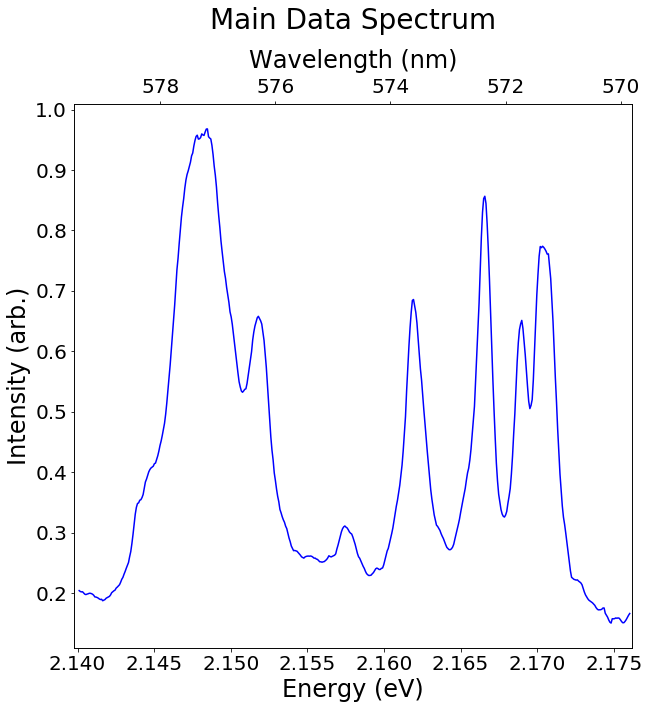

In [4]:
### EDIT THIS CELL ###

# To load the data you want into the tool, first upload the .spe file from
# the PC to this folder in google drive. Once you have that, modify the two
# variables below to be strings containing the exact titles of the .spe files
# you are interested in without any file extensions

# direc_data should be a string containing the directory in which the actual
# spectroscopic data is stored.
# fn_data should be the title of the file containing the actual spectroscopic
# data (either PL or absorption)

direc_data = 'C:\\Users\\pcadm\\Documents\\Stephan Transparent Sample\\LightField Data'
fn_data = '8-4-22 Temperature Dependent Yellow Exciton PL, T = 5 K, P = 50 uW, (4500, 402)'

# NORMALIZE is a parameter determining whether or not you want to normalize
# the input data. Usually, you can set this to True, but if you are trying to
# get an exact OD measurement (not in arbitrary units) you should set this to
# False.

NORMALIZE = True

# ROI is a parameter which specifies you region of interest. It is a list which
# contains two parameters. The first is a lower bound (in nm) and the second
# is an upper bound. This will allow you to zoom in on the area of the spectrum
# you are most interested in (for example, the region of the yellow exciton
# series). The graphs outputted underneath this cell will allow you to verify
# that you are zoomed in suitably

ROI = [569.8, 579.5]

### STOP EDITING HERE ###

### CHECK THE OUTPUT PLOT TO MAKE SURE IT IS THE DATA YOU ARE INTERESTED IN ###

# Read in main data
wavelength, intensity = gm.get_integrated_info(direc_data, fn_data, normalized = NORMALIZE,
                                                 offline = False)

# Clip data down to range specified by ROI

# Runners represent the indices. They will be iterated until they find the
# points just above or below the bounds specified by ROI
main_low_runner = 0
main_high_runner = 0

while wavelength[main_low_runner] < ROI[0] and main_low_runner < len(wavelength) - 1:
    main_low_runner += 1

while wavelength[main_high_runner] < ROI[1] and main_high_runner < len(wavelength) - 1:
    main_high_runner += 1

# Perform clipping
wavelength = wavelength[main_low_runner:main_high_runner]
intensity = intensity[main_low_runner:main_high_runner]

# Correct for dichroic
intensity = dichroic_correct(wavelength, intensity)

# Renormalize if necessary
if NORMALIZE:
    intensity = intensity / np.max(intensity)

# Take screened wavelength
wavelength, intensity = gm.moving_avg(wavelength, intensity, screen_size = 5)

# Plot main data
cl = np.array([1000])
gm.plot_data([wavelength],
                     [intensity],
                     [],
                     [],
                        cutoff_lams = cl, plot_mode = 'multi', xlim = ROI, 
                        legend_lst = None,
                        screened_legend_lst = None,
                        title = 'Main Data Spectrum')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27d79993148>)

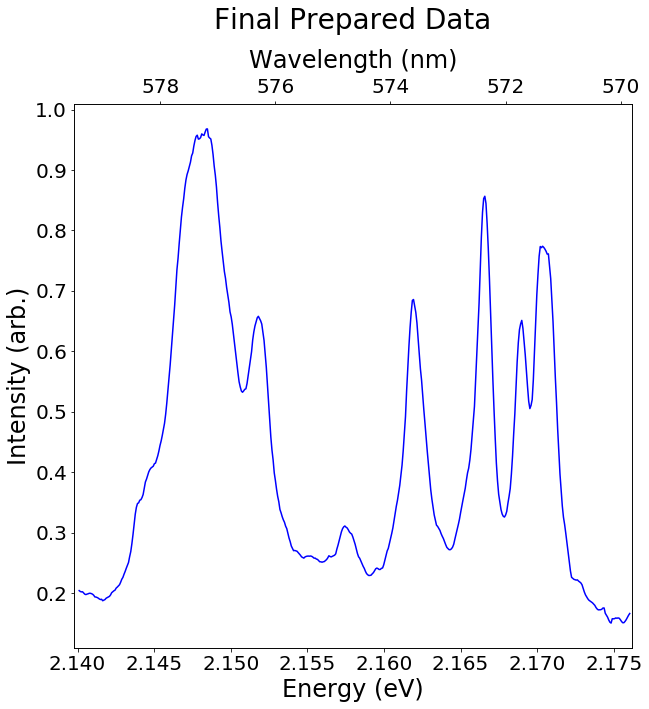

In [5]:
### EDIT THIS CELL ###

# In this cell you will finalize the form of your data that will be passed to
# the actual Bayesian inference algorithm. If you want to perform background
# subtraction, do that here. If you want to convert to absorption coefficient
# or OD, do that here. Either way, after running this cell you should have
# defined two new variables: bayesian_x and bayesian_y. If you have no other
# modifications you wish to make to your data, simply set
# bayesian_x = wavelength
# bayesian_y = intensity.
# Otherwise, set these variables to the outputs of your data manipulations.

# Note: when performing background subtraction, a quadratic fit has been
# pre-prepared to model your background data. Simply call the method
# background_fit(wavelength) when doing your background subtraction.

bayesian_x = wavelength
bayesian_y = intensity

### STOP EDITING HERE ###

### CHECK THE PLOT BELOW TO MAKE SURE THIS IS WHAT YOU WANT TO PLOT ###

# Plot background data
gm.plot_data([bayesian_x],
             [bayesian_y],
             [],
             [],
             cutoff_lams = cl, plot_mode = 'multi', xlim = ROI,
             legend_lst = None,
             screened_legend_lst = None,
             title = 'Final Prepared Data')

In [6]:
### DO NOT EDIT THIS CELL ###

def fano(x, theta):
    x0 = theta[0]
    gam = theta[1] * 0.5
    q = theta[2]
    height = theta[3]
    
    return height * (gam + 2 * q * (x - x0)) / (gam ** 2 + (x - x0) ** 2)

def n_peak_model(n, x, theta):
    E = nm_ev_conv / x
    
    Eg = theta[0] # Band gap energy
    Ry = theta[1] # Rydberg energy
    offset = theta[2] # Offset
    E_1sg = theta[3] # Center energy of 1s green peak
    FWHM_1sg = theta[4] # FWHM of 1s green peak
    q_1sg = theta[5] # Asymmetry of 1s green peak
    height_1sg = theta[6] # Height of 1s green peak
    
    lam_1sg = nm_ev_conv / E_1sg
    output = offset + fano(x, [lam_1sg, FWHM_1sg, q_1sg, height_1sg])
    
    for ii in range(n):
        N = ii + 2
        delta = theta[7 + 4 * ii]
        FWHM = theta[8 + 4 * ii]
        q = theta[9 + 4 * ii]
        height = theta[10 + 4 * ii]
        
        En = Eg - Ry / (N - delta) ** 2
        
        lamn = nm_ev_conv / En

        output = output + fano(x, [lamn, FWHM, q, height])
    
    return output

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27d7981d608>)

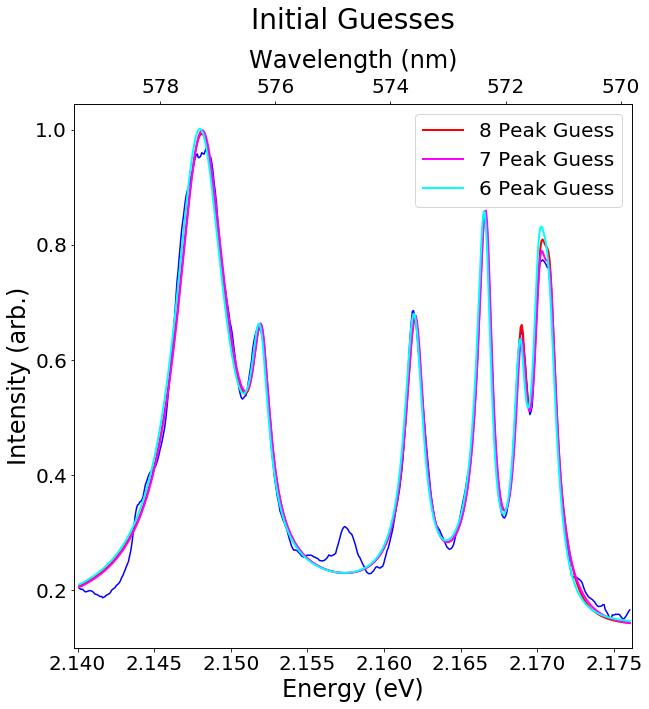

In [7]:
### EDIT THIS CELL ###

# In this cell, we will define the model we will be using for our peak finding.
# First, we need to decide which models we want to test (i.e., how many peaks
# we want to look for). nmin is an argument describing the minimum number of
# peaks you want to check for. nmax is a variable describing the largest number
# of peaks you want to look for. Define them appropriately.

nmin = 6
nmax = 8

# There are two types of parameters in our model: peak-dependent and peak-
# independent parameters. Peak-dependent parameters change depending on which
# peak you are talking about (an example of this would be the linewidth of a
# given peak), peak-independent parameters do not (an example of this would be
# the band gap energy of the system). The variable names and a description
# of each parameter are given below.

# PEAK-INDEPENDENT PARAMETERS
# Eg - The bandgap energy of the system (defined in eV)
# Ry - The Rydberg binding energy (defined in meV)
# sigma - The inhomogeneous broadening (defined in nm)
# a0 - The Urbach absorption coefficient (unitless)
# Eu - The Urbach energy (defined in eV)
# offset - A set bias of the data from the x-axis (unitless)

# PEAK-DEPENDENT PARAMETERS
# delta - The quantum defect of a particular peak (unitless)
# FWHM - the full-width half-max of the peak (defined in nm)
# q - The Fano assymmetry factor of the peak (unitless)
# height - A scaling parameter that controls for the height of the peaks (unitless)

# Now that we understand this, we need to define our initial guesses.
# Define the argument theta_init below to be a list of guess fit parameters
# for the maximum number of peaks you want to find. For example, if you want to
# find a maximum of 5 peaks you will have 26 fit parameters (6 peak-
# independent parameters and 4 peak-dependent parameters for each peak). The
# order in which you list these is important. They should be formatted as in 
# this example:

#           example = [Eg, Ry, sigma, a0, Eu, offset,  <--- Peak-independent parameters
#                      delta1, FWHM1, q1, height1, <--- Peak-dpendent parameters for first peak
#                      delta2, FWHM2, q2, height2, <--- Peak-dpendent parameters for second peak
#                      delta3, FWHM3, q3, height3, <--- Peak-dpendent parameters for third peak
#                                     .
#                                     .
#                                     .
#                      delta_n, FWHM_n, q_n, height_n] <--- Peak-dpendent parameters for last peak

# You only need to do this for the highest number of peaks you wish to look for.
# All fit parameters besides those for the last few peaks will be the same
# for all other models being tested.
theta_init_arr = {}

theta_init_arr[6] = [2.1727, 0.0906, 0.1482, 2.1519, 0.3721, 0.0054, 0.0591,
                 0.0859, 1.1004, 0.00049, 0.4565,
                 0.0911, 0.3942, 0.0587, 0.0924,
                 0.1413, 0.3041, 0.1423, 0.0968,
                 0.1232, 0.2482, 0.0701, 0.0457,
                 0.0825, 0.2487, 0.0185, 0.0439,
                 0.2362, 0.3614, 0.0233, 0.0886]

theta_init_arr[7] = [2.1729, 0.0934, 0.1441, 2.152, 0.3724, 0.004, 0.0587,
              0.0585, 1.1032, 0.0005, 0.4579,
              0.0611, 0.3964, 0.0669, 0.0926,
              0.1206, 0.3036, 0.1311, 0.0968,
              0.1138, 0.2425, 0.0773, 0.0436,
              0.1091, 0.2544, 0.0277, 0.0487,
              0.2282, 0.2806, 0.0294, 0.0565,
              0.1884, 0.9098, 0.1022, 0.0338]

theta_init_arr[8] = [2.1729, 0.0943, 0.1464, 2.152, 0.3722, 0.006, 0.0591,
              0.0506, 1.1049, 0.0005, 0.4541,
              0.0485, 0.3977, 0.064, 0.0914,
              0.1085, 0.3030, 0.1297, 0.0959,
              0.0949, 0.2396, 0.0767, 0.0461,
              0.076, 0.2692, 0.0202, 0.0541,
              0.2147, 0.2793, 0.042, 0.0557,
              0.1453, 0.7311, 0.1093, 0.0200,
              0.1671, 0.4381, 0.0385, 0.0050]


### STOP EDITING HERE ###

num_models = nmax - nmin + 1
models_arr = {}

for ii in range(num_models):
    ntemp = nmin + ii
    models_arr[ntemp] = lambda x, theta, nval=ntemp: n_peak_model(nval, x, theta)
#    if ntemp <= 4:
#        theta_init_arr[ntemp] = theta_init[0:12 + 4 * (ntemp - 1)]
#    else:
#        theta_init_arr[ntemp] = theta_init[0:27 + 3 * (ntemp - 5)]

guess_plot_arr = []
guess_legend_label_arr = []
for n in range(nmax, nmin - 1, -1):
    guess_plot_arr.append(models_arr[n](bayesian_x, theta_init_arr[n]))
    guess_legend_label_arr.append(str(n) + ' Peak Guess')

gm.plot_data([bayesian_x],
             [bayesian_y],
             [bayesian_x] * num_models,
             guess_plot_arr,
             cutoff_lams = cl, plot_mode = 'multi', xlim = ROI,
             legend_lst = None,
             screened_legend_lst = guess_legend_label_arr,
             title = 'Initial Guesses')

In [8]:
### EDIT THIS CELL ###

# Next, we have to give the standard deviations with which we will randomly
# iterate our fit parameters. To ensure convergence, these should be roughly
# 2 to 3 orders of magnitude smaller than the guess fit parameters they are
# iterating. Assign these values in a list to the variable sig_theta. The
# order of this list should correspond to the order you used when defining
# theta_init. Again, you only need to do this for the maximum number of peaks
# you are looking for.

sig_theta = np.array([1e-5, 1e-5, 1e-4, 1e-5, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3,
             1e-3, 1e-3, 1e-4, 1e-3])


#theta_init = [2.1728, 0.094, 0.21, 2.152, 0.5, 0.1, 0.08, 0.09,
#              0.01, 1, 0.2, 0.3,
#              0.03, 0.5, 0.2, 0.1,
#              0.04, 0.3, 0.2, 0.08,
#              0.06, 0.2, 0.2, 0.05,
#              0.15, 0, 0.04,
#              0.1, 0, 0.03,
#              0.1, 0, 0.02]

# Next we need to set the upper and lower bounds for our fit parameters.
# As a rule of thumb, these should be as unrestrictive as possible (i.e.,
# do not try to force a certain value onto the data). However, in certain cases
# you might set more restrictive bounds (for example you might restrict the
# quantum defects to the values you find in the literature). Assign the upper
# bounds to the variable theta_upper and the lower bounds to the variable 
# theta_lower, being sure to observe the correct order.

theta_upper = np.array([100, 100, 100, 100, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100,
                        0.5, 100, 100, 100])

theta_lower = np.array([0, 0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0])

### STOP EDITING HERE ###

sig_theta_arr = {}
theta_upper_arr = {}
theta_lower_arr = {}

for ii in range(num_models):
    ntemp = nmin + ii
    sig_theta_arr[ntemp] = sig_theta[0:11 + 4 * (ntemp - 1)]
    theta_upper_arr[ntemp] = theta_upper[0:11 + 4 * (ntemp - 1)]
    theta_lower_arr[ntemp] = theta_lower[0:11 + 4 * (ntemp - 1)]

In [9]:
### EDIT THIS CELL ###

# We now need to initialize our replicas, meaning we need to generate a list of
# possible background noise levels. First, decide the minimum and maximum values
# of the background noise you would like to test and assign these to the
# variables noise_min and noise_max

noise_min = 5e-3
noise_max = 1e-1

# Next decide how many replicas you want and assign it to the variable
# num_replicas (usually you want between 100 and 200)

num_replicas = 30

### STOP EDITING HERE ###

bmax = 1 / noise_min ** 2
bmin = 1 / noise_max ** 2
b_rat = (bmax / bmin) ** (1 / (num_replicas - 1))
print(b_rat)

noise_b_arr = np.array([bmin * b_rat ** ii for ii in range(num_replicas)])
noise_sig_arr = np.sqrt(1 / noise_b_arr)

1.229493413694625


In [10]:
### EDIT THIS CELL ###

# Decide how many iterations of the replica exchange model you want to run and
# assign this value to the variable num_iters

num_iters = 500000

### STOP EDITING HERE ###

theta_info = {}
P_D_theta_info = {}
acceptance_ratios = {}

# Run replica exchange method
for n in theta_init_arr:
    ref_time = time.time()
    theta_info[n], P_D_theta_info[n], acceptance_ratios[n] = met.replica_exchange(bayesian_x,
                       bayesian_y, models_arr[n], theta_init_arr[n],
                       sig_theta_arr[n], theta_lower_arr[n], theta_upper_arr[n],
                       noise_sig_arr, num_iter = num_iters)
  
    # List time taken to analyze each model
    timer = time.time() - ref_time
    hours = round(timer // 3600)
    minutes = round((timer - 3600 * hours) // 60)
    seconds = round(timer - 3600 * hours - 60 * minutes)
    print(f"Finished {n} peak model analysis. Elapsed time {hours} hours, {minutes} minutes, {seconds} seconds")

True exchanges: 30.48%
Random exchanges: 30.47%

Time Diagnostics:
----------------------------------
Time Spent Metropolis Stepping: 44 minutes and 6 seconds
Time Spent Replica Exchanging: 19 minutes and 33 seconds
Time Spent E Calculating: 1 seconds

Finished 6 peak model analysis. Elapsed time 1 hours, 3 minutes, 41 seconds
True exchanges: 30.04%
Random exchanges: 30.03%

Time Diagnostics:
----------------------------------
Time Spent Metropolis Stepping: 51 minutes and 0 seconds
Time Spent Replica Exchanging: 22 minutes and 17 seconds
Time Spent E Calculating: 1 seconds

Finished 7 peak model analysis. Elapsed time 1 hours, 13 minutes, 20 seconds
True exchanges: 29.53%
Random exchanges: 29.52%

Time Diagnostics:
----------------------------------
Time Spent Metropolis Stepping: 56 minutes and 15 seconds
Time Spent Replica Exchanging: 24 minutes and 41 seconds
Time Spent E Calculating: 1 seconds

Finished 8 peak model analysis. Elapsed time 1 hours, 20 minutes, 59 seconds


C:\Users\pcadm\Documents\QNP Code\QNP Code - Copy\Metropolis.py:292: RuntimeWarning: divide by zero encountered in log
  temp += np.log(np.mean(temp_arr))


The 6 peak model has background noise with standard deviation 0.023545968236365622
The 7 peak model has background noise with standard deviation 0.023545968236365622
The 8 peak model has background noise with standard deviation 0.023545968236365622

6 peak model acceptance ratio: 9.39%
7 peak model acceptance ratio: 9.08%
8 peak model acceptance ratio: 7.69%


(-1108.2060768337567, -1104.8695931399704)

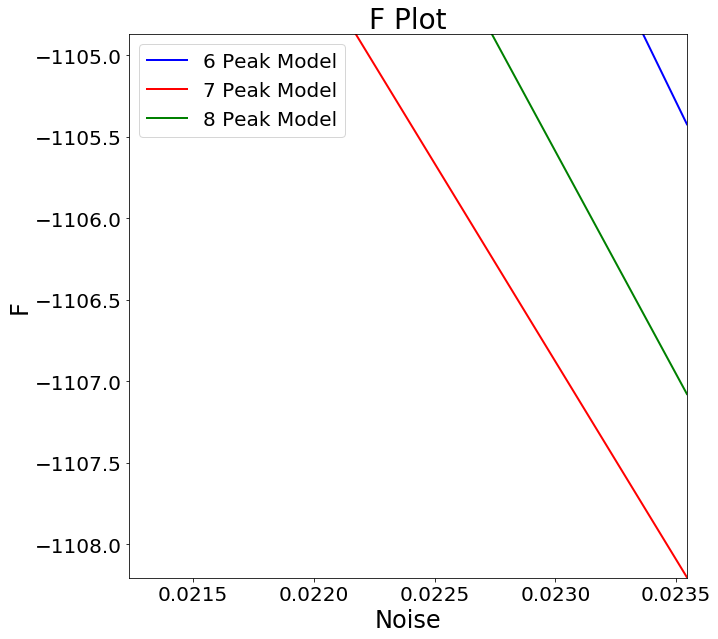

In [11]:
### DO NOT EDIT, BUT DO READ THIS CELL ###

# This cell outputs a plot of the F values for each model. This is where you
# make a judgment about how many peaks you are actually seeing. Besides tweaking
# the limits on the axes of the plot, you should not need to change anything.

# Find the minima of the F curves and the indices at which they occur
F_arrs = {}
F_indices = {}
for ii in range(nmin, nmax + 1):
    F_arrs[ii] = met.F_approx(P_D_theta_info[ii], noise_b_arr, len(bayesian_x), num_iters)
    temp = 0
    temp_min = abs(np.max(F_arrs[ii])) * 2
    for jj in range(len(F_arrs[ii])):
        if F_arrs[ii][jj] < temp_min:
            temp_min = F_arrs[ii][jj]
            temp = jj
    F_indices[ii] = temp
    print(f"The {ii} peak model has background noise with standard deviation {noise_sig_arr[temp]}")
    
# Print acceptance ratios
print('')
for ii in range(nmin, nmax + 1):
    print(f'{ii} peak model acceptance ratio: {acceptance_ratios[ii][F_indices[ii]]}%')

zoom_ratio_high = 0.2
zoom_ratio_low = 0.0001
plot_F_min = min([F_arrs[n][F_indices[n]] for n in range(nmin, nmax + 1)])
plot_F_max = max([F_arrs[n][F_indices[n]] for n in range(nmin, nmax + 1)])
plot_F_range = abs(plot_F_max - plot_F_min)
plot_min = plot_F_min - zoom_ratio_low * abs(plot_F_range)
plot_max = plot_F_max + zoom_ratio_high * abs(plot_F_range)

def over_checker(idx, compare_val):
    flag_out = True
    for n in F_arrs:
        flag_out *= (F_arrs[n][idx] > compare_val)
  
    return flag_out

def under_checker(idx, compare_val):
    flag_out = True
    for n in F_arrs:
        flag_out *= (F_arrs[n][idx] < compare_val)
  
    return flag_out

plot_max_idx = 0
while over_checker(plot_max_idx, plot_max) and plot_max_idx < num_replicas - 1:
    plot_max_idx += 1

plot_min_idx = plot_max_idx

while not over_checker(plot_min_idx, plot_max) and plot_min_idx < num_replicas - 1:
    plot_min_idx += 1

plot_x_min = noise_sig_arr[plot_min_idx]
plot_x_max = noise_sig_arr[plot_max_idx]

c_arr = ['blue', 'red', 'green', 'black', 'magenta']
plt.figure(figsize = (10, 10))
for ii in range(num_models):
    plt.plot(noise_sig_arr, F_arrs[nmin + ii], color = c_arr[ii], linewidth = 2,
               label = str(nmin + ii) + ' Peak Model')

plt.xlabel('Noise', size = 24)
plt.ylabel('F', size = 24)
plt.title('F Plot', size = 28)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop = {'size':20})
plt.xlim([plot_x_min, plot_x_max])
plt.ylim([plot_min, plot_max])
#plt.xlim([0.02, 0.06])
#plt.ylim([-1000, -200])

# If you wish to adjust the zoom on the plot, please do so with comands below
# point. Modifying the code above will mess with the auto-zoom.

In [12]:
### DO NOT EDIT THIS CELL ###

params = {}
param_names = {}
param_means = {}
param_stds = {}

# Method to generate a list of parameter names for an n peak model
def gen_param_names(n):
    out_length = 7 + 4 * n
    output = [0] * out_length
    output[0] = 'Eg'
    output[1] = 'Ry'
    output[2] = 'Offset'
    output[3] = 'E1sg'
    output[4] = 'FWHM 1sg'
    output[5] = 'q 1sg'
    output[6] = 'Height 1sg'
    
    for ii in range(n):
        output[7 + 4 * ii] = 'Q. Def. ' + str(ii + 1)
        output[8 + 4 * ii] = 'FWHM ' + str(ii + 1)
        output[9 + 4 * ii] = 'q ' + str(ii + 1)
        output[10 + 4 * ii] = 'Height ' + str(ii + 1)
    
    return output
    
for ii in range(nmin, nmax + 1):
    params[ii] = theta_info[ii][F_indices[ii], :, :]
    param_names[ii] = gen_param_names(ii)
    param_means[ii], param_stds[ii] = met.param_sum(theta_info[ii], F_indices[ii])

# Method to plot histograms of all fit parameters for a given model
def plot_hists():
    n_list = np.array([x for x in range(nmin, nmax + 1)])
    
    num_rows = len(param_names[nmax])
    
    for jj in range(num_rows):
        num_plots = 0
        for n in param_names:
            if jj < len(param_names[n]):
                num_plots += 1
        fig, axs = plt.subplots(1, num_plots)
        fig.set_figheight(5)
        fig.set_figwidth(5 * num_plots)
        for kk in range(num_plots):
            if num_plots > 1:
                n_temp = nmax - num_plots + kk + 1
                axs[kk].hist(params[n_temp][num_iters//2::, jj])
                axs[kk].set_title(param_names[n_temp][jj] + ' from ' + str(n_temp) + ' Peak Model')
            else:
                n_temp = nmax - num_plots + kk + 1
                axs.hist(params[n_temp][num_iters//2::, jj])
                axs.set_title(param_names[n_temp][jj] + ' from ' + str(n_temp) + ' Peak Model')

def plot_best_fits():
    for ii in range(nmin, nmax + 1):
        best_fit_y = models_arr[ii](bayesian_x, param_means[ii])
        resid_y = bayesian_y - best_fit_y
        gm.plot_data([bayesian_x],
             [bayesian_y],
             [bayesian_x],
             [best_fit_y],
             cutoff_lams = cl, plot_mode = 'multi', xlim = ROI,
             legend_lst = ['Data'],
             screened_legend_lst = [str(ii) + ' Peak Fit'],
             title = 'Plot of Best ' + str(ii) + ' Peak Fit')
        
        gm.plot_data([bayesian_x],
             [resid_y],
             [],
             [],
             cutoff_lams = cl, plot_mode = 'multi', xlim = ROI,
             legend_lst = None,
             screened_legend_lst = None,
             title = 'Plot of Residuals for Best ' + str(ii) + ' Peak Fit')

def list_params():
    eps = 1e-10
    
    for ii in range(nmin, nmax + 1):
        print(f"{ii} Peak Model")
        print('----------------------------------------------------------')
        print('')
        temp_means = param_means[ii]
        temp_stds = param_stds[ii]
        for jj in range(len(temp_means)):
            power_mean = np.floor(np.log(abs(temp_means[jj]) + eps) / np.log(10))
            power_std = np.floor(np.log(abs(temp_stds[jj]) + eps) / np.log(10))
            power = max(power_mean, power_std)
            if power > -4:
                mean_roundoff = 4
                std_roundoff = 6
            elif power == -4:
                mean_roundoff = 5
                std_roundoff = 7
            else:
                mean_round_off = abs(power) + 1
                std_round_off = abs(power) + 3
            print(f"{param_names[ii][jj]}: {round(temp_means[jj], mean_roundoff)} +/- {round(temp_stds[jj], std_roundoff)}")
        print('')
        print('')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


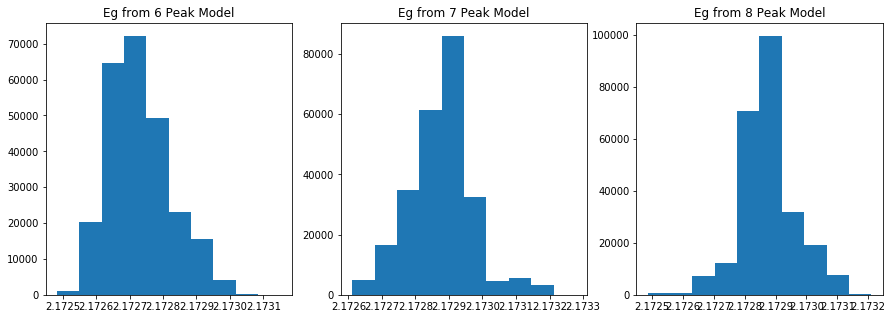

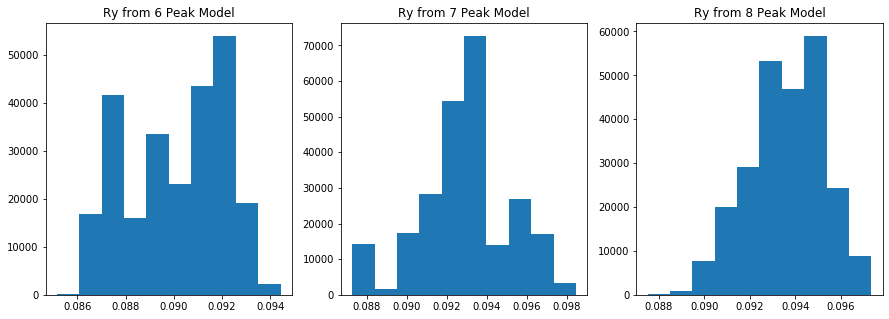

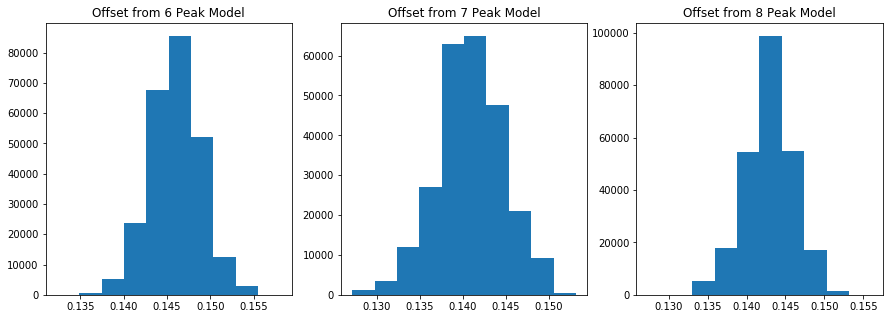

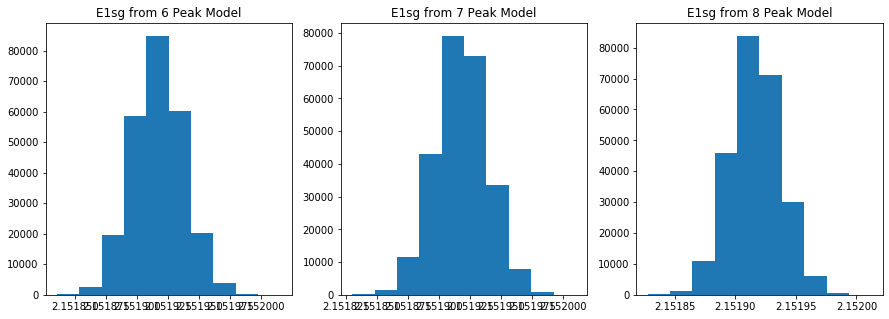

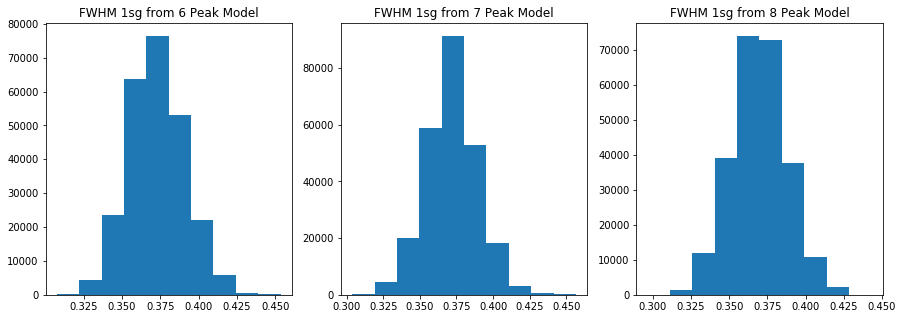

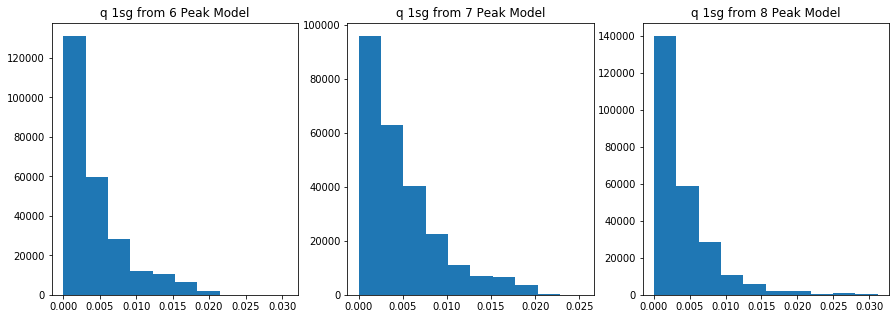

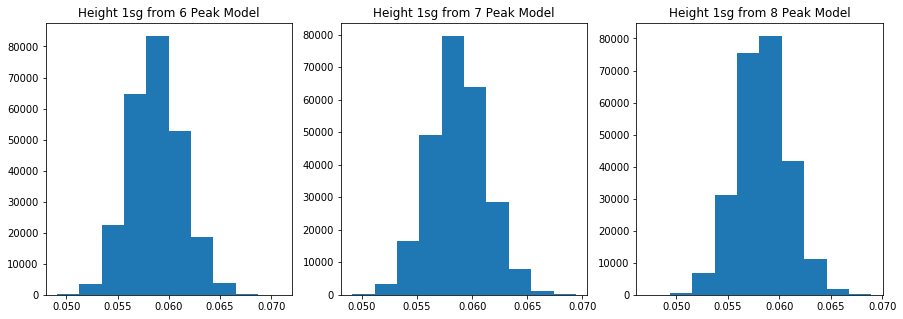

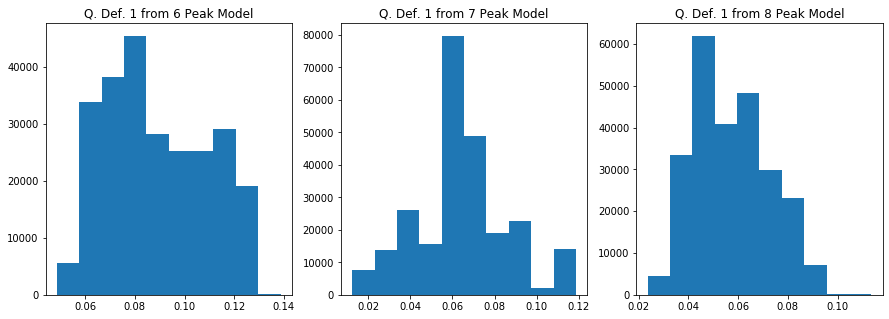

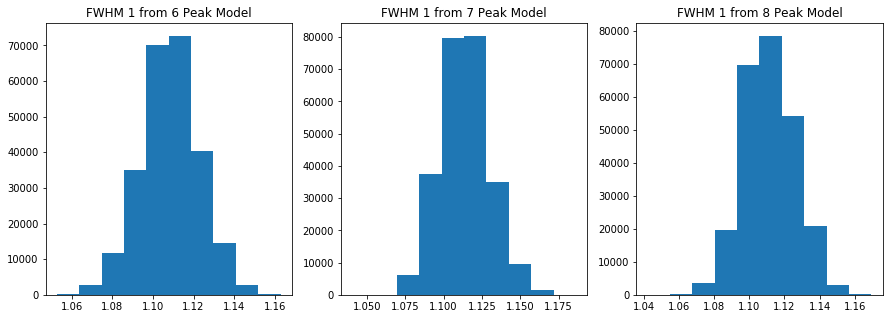

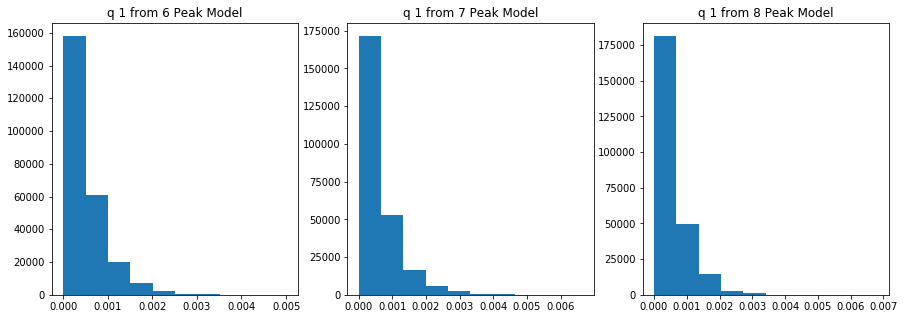

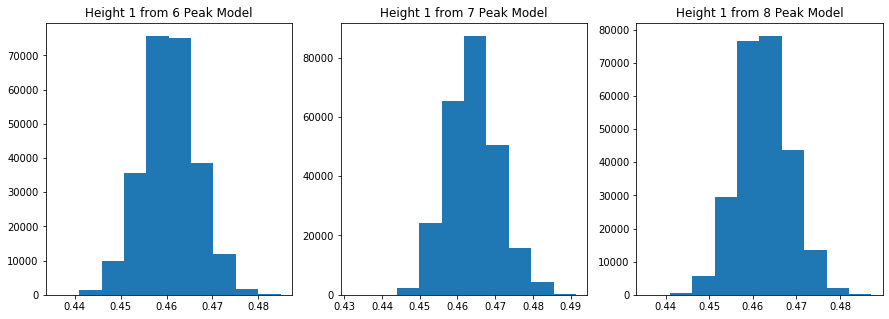

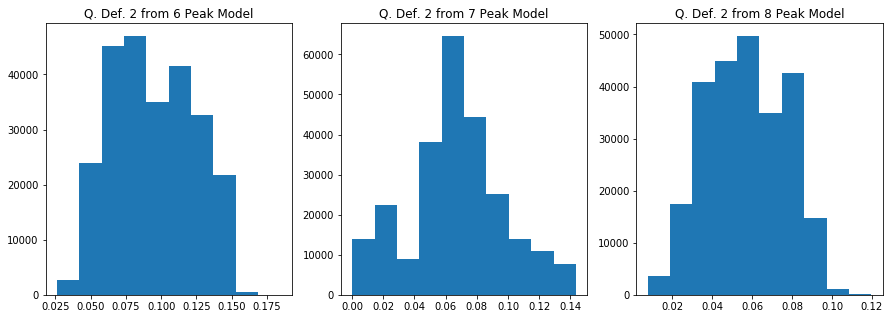

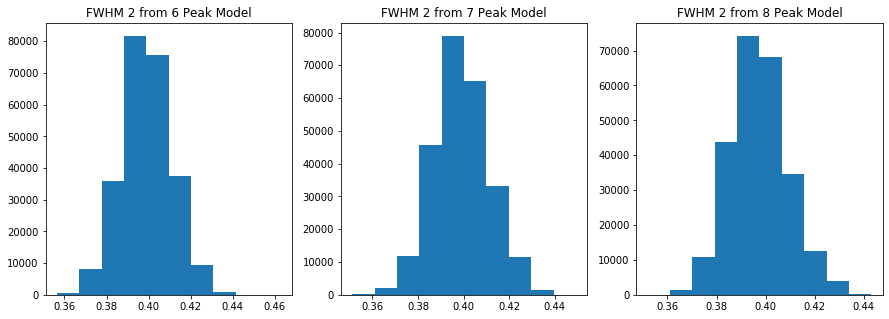

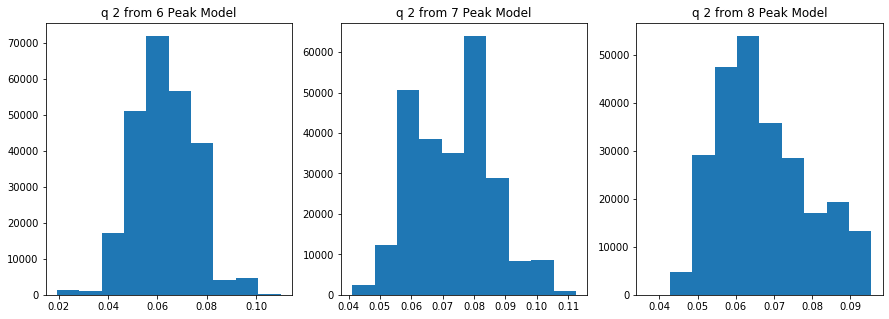

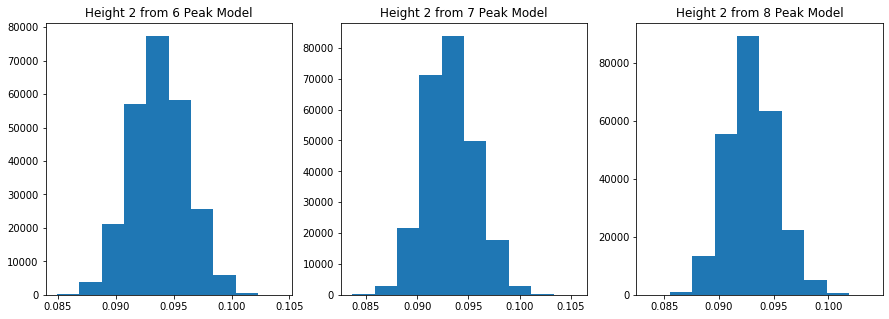

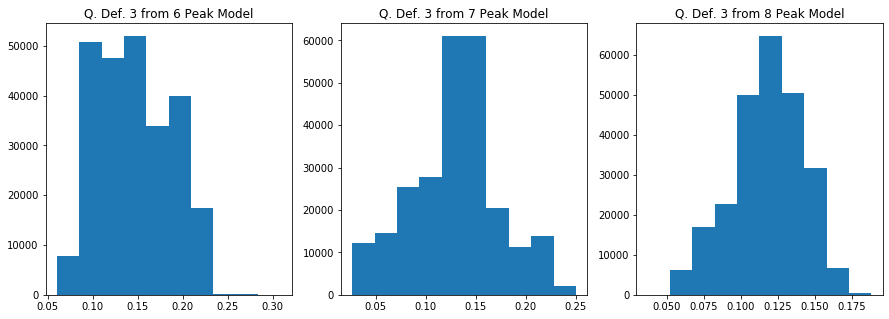

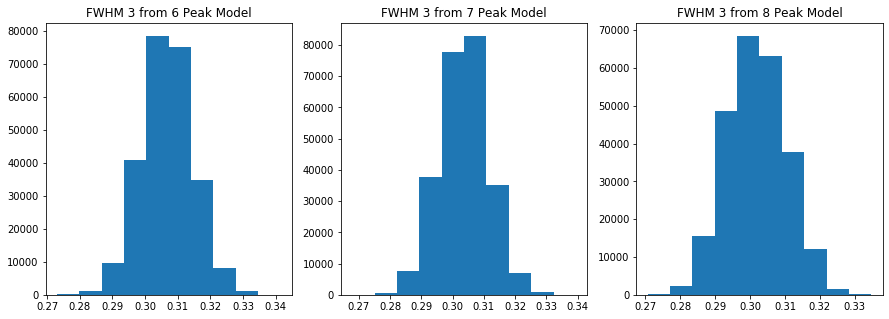

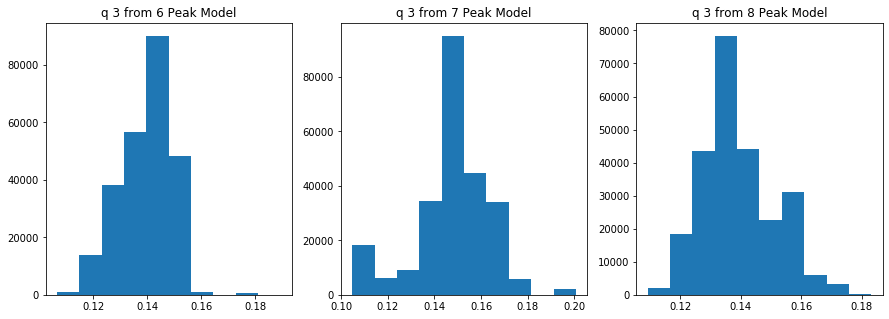

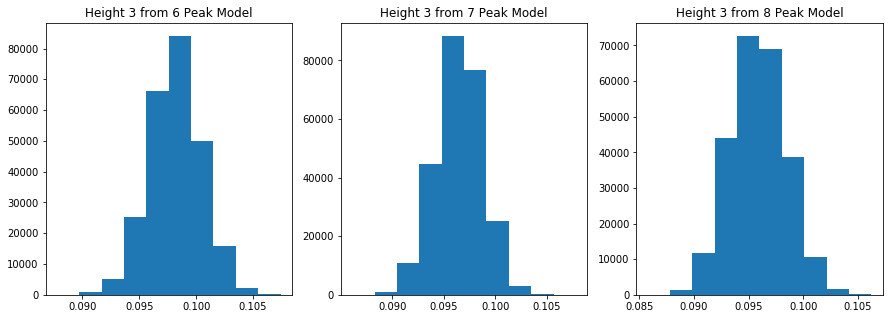

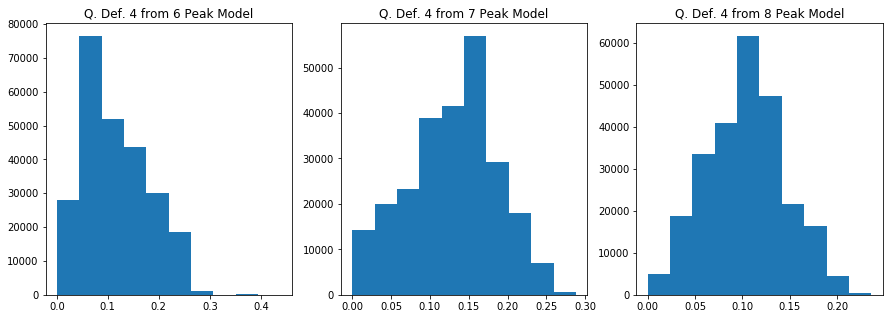

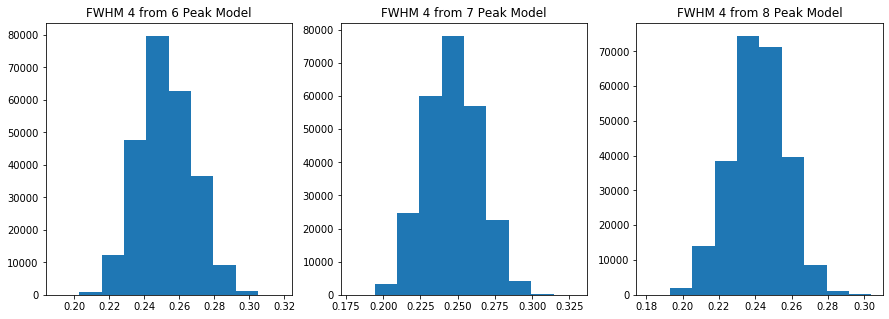

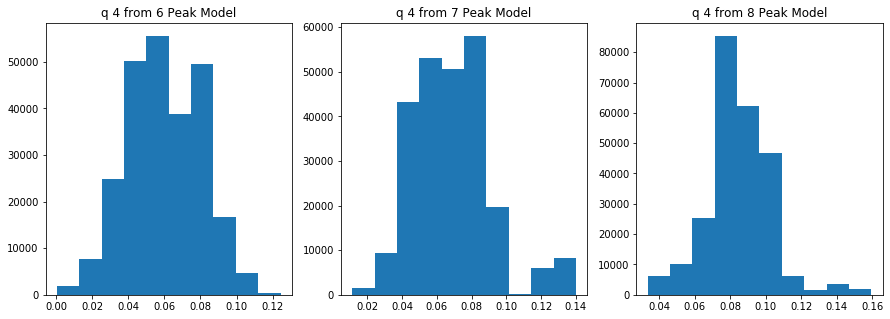

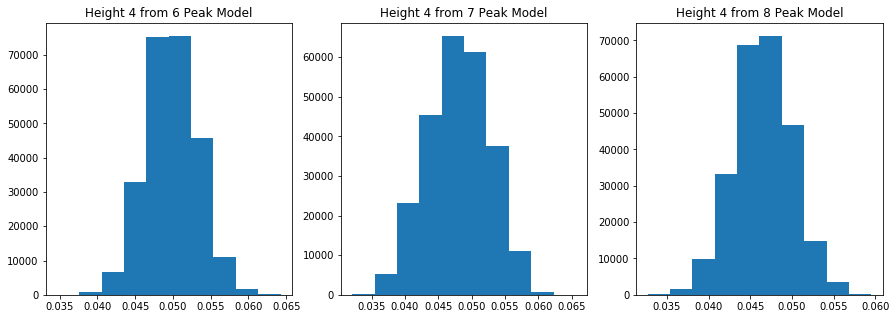

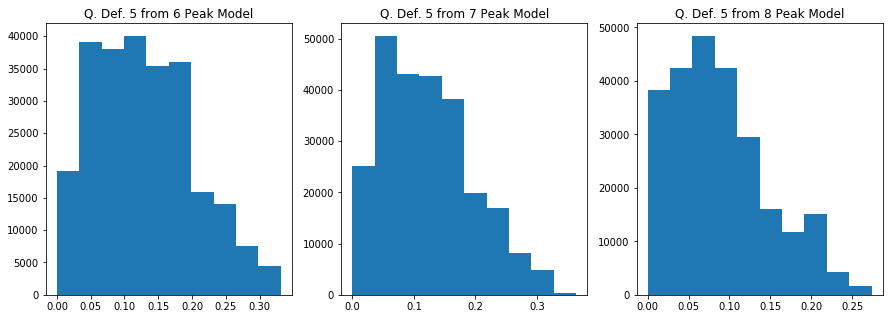

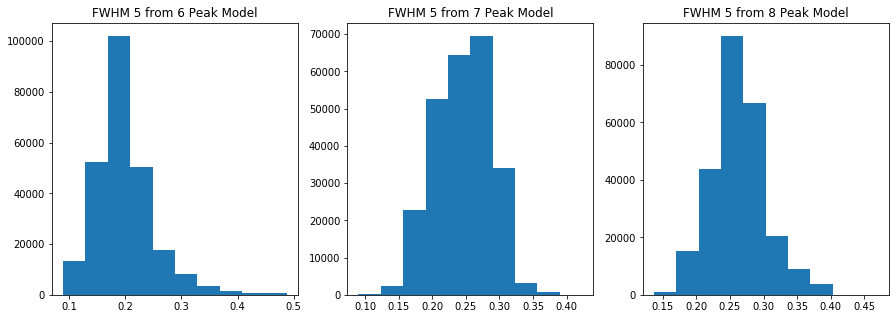

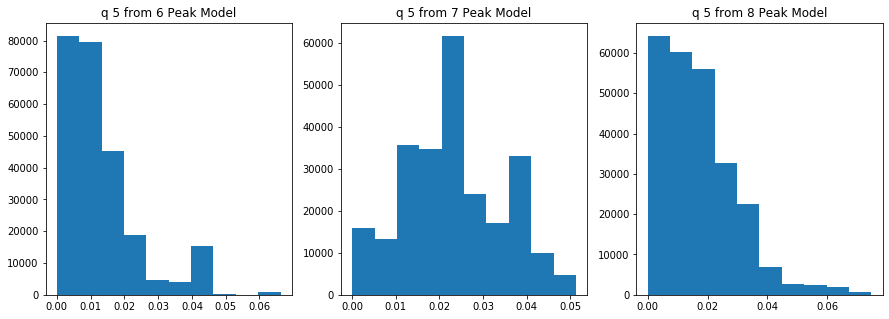

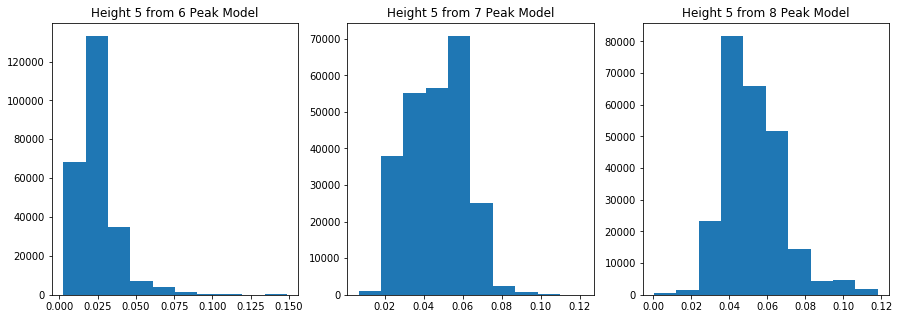

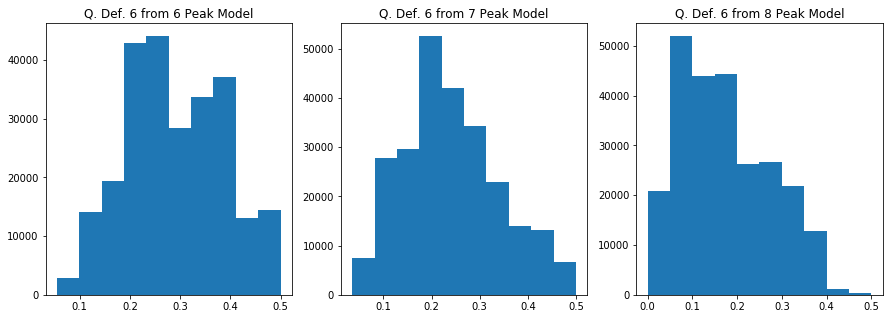

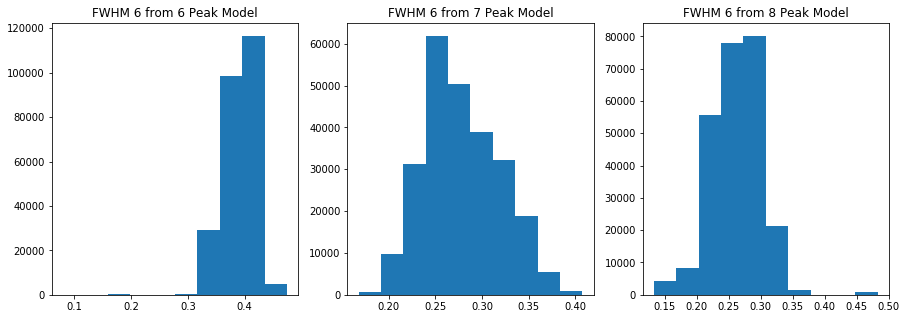

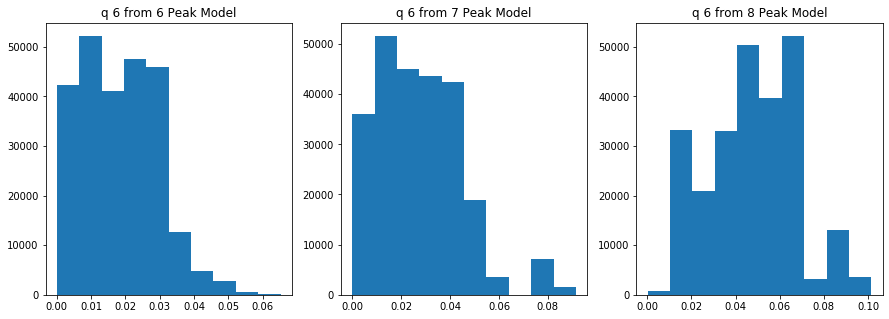

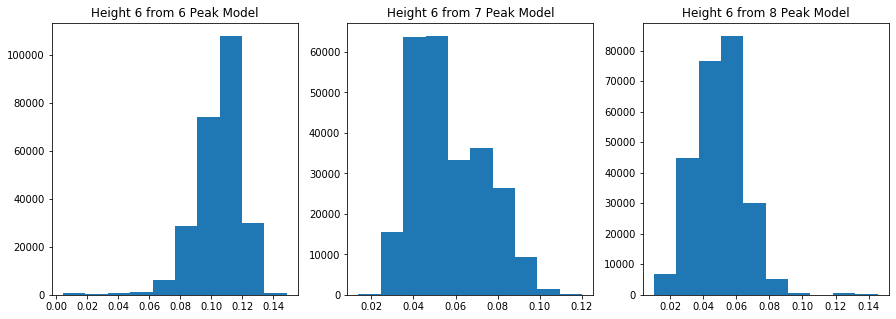

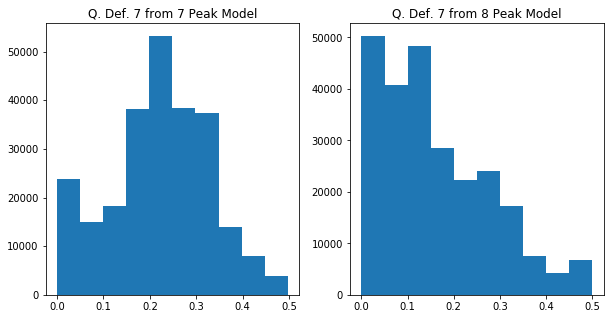

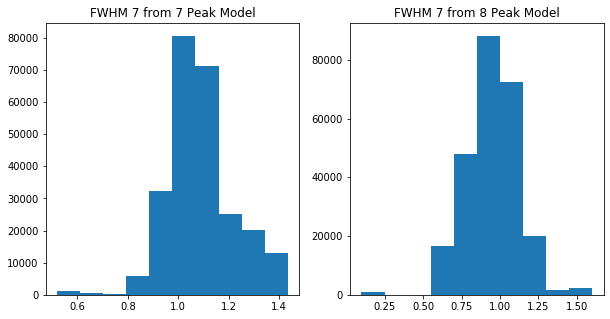

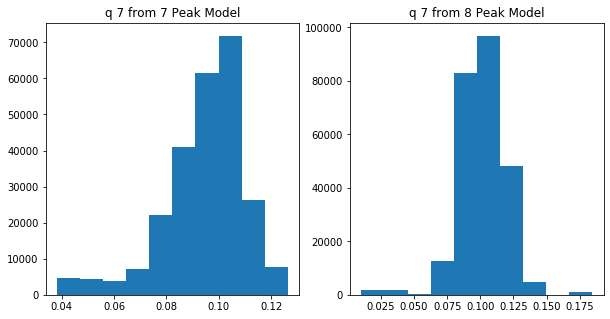

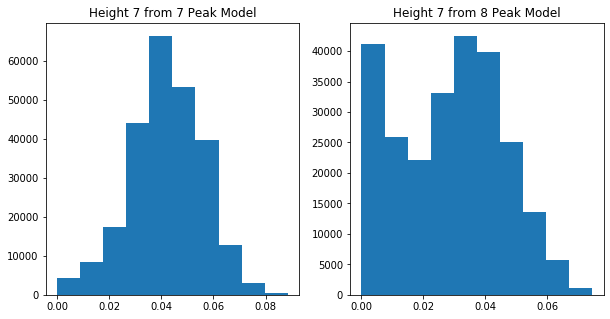

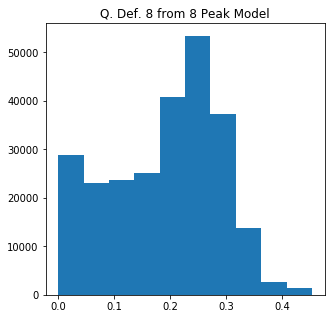

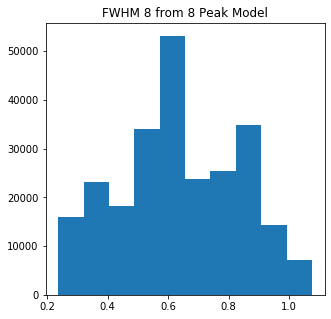

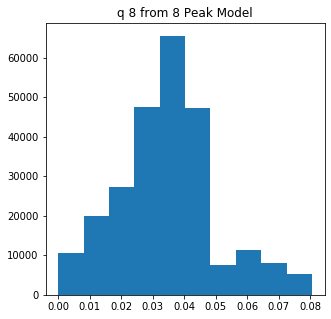

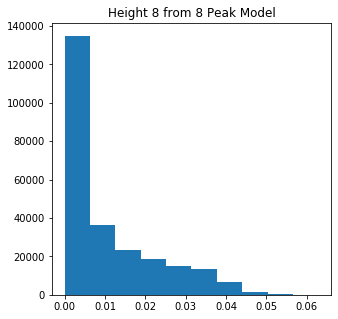

In [13]:
### DO NOT EDIT THIS CELL, BUT DO LOOK AT THE OUTPUT ###

# When running Bayesian analysis, it is important to choose
# the values of sig_theta carefully to ensure that your
# algorithm converges in a reasonable amount of time.
# Before committing to a run of tens or even hundreds
# of thousands of iterations, perform a run of 20-30
# iterations and look at the outputs of these histograms
# to ensrue that the values of your fit parameters are indeed
# changing between iterations. If instead of several distinct
# bars you see only one bar, you have chosen your sig_theta
# values too large.

plot_hists()

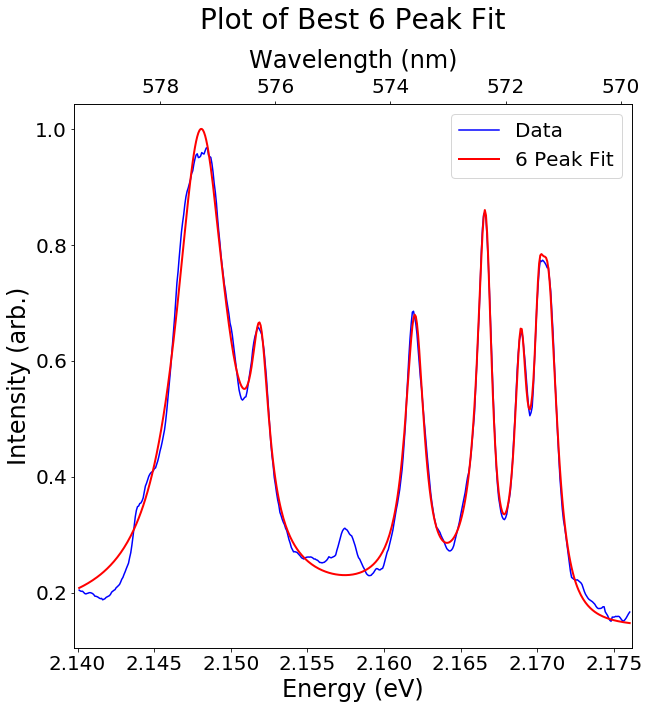

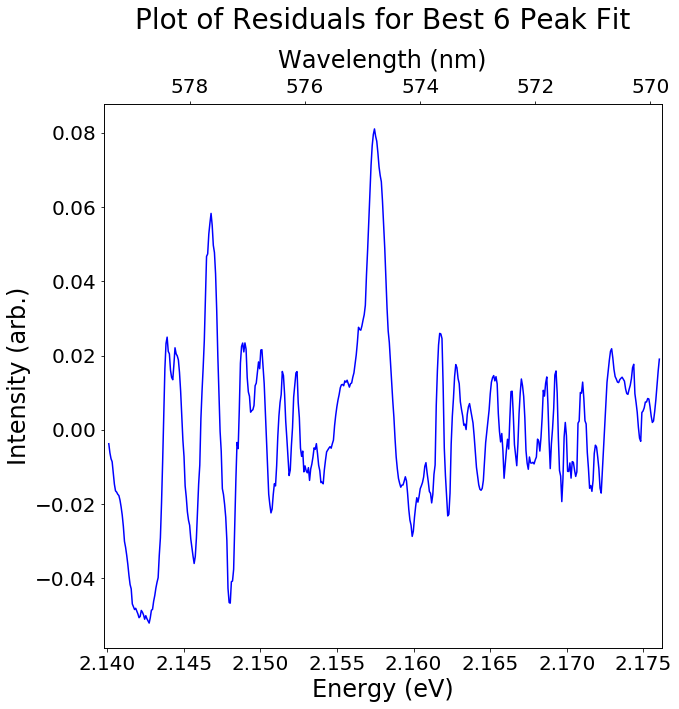

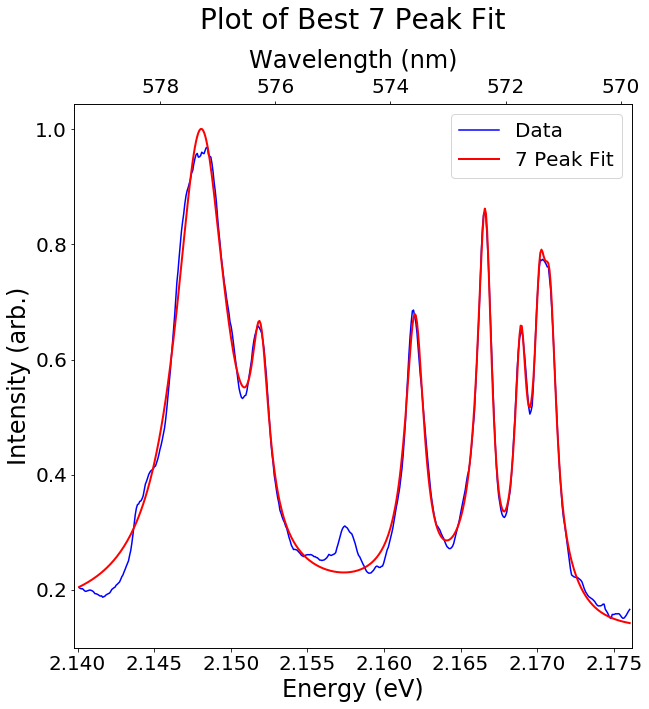

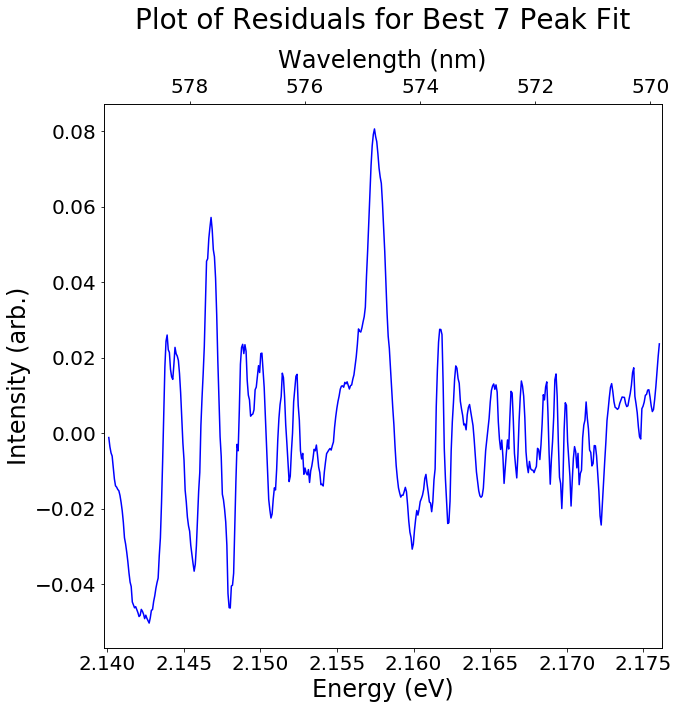

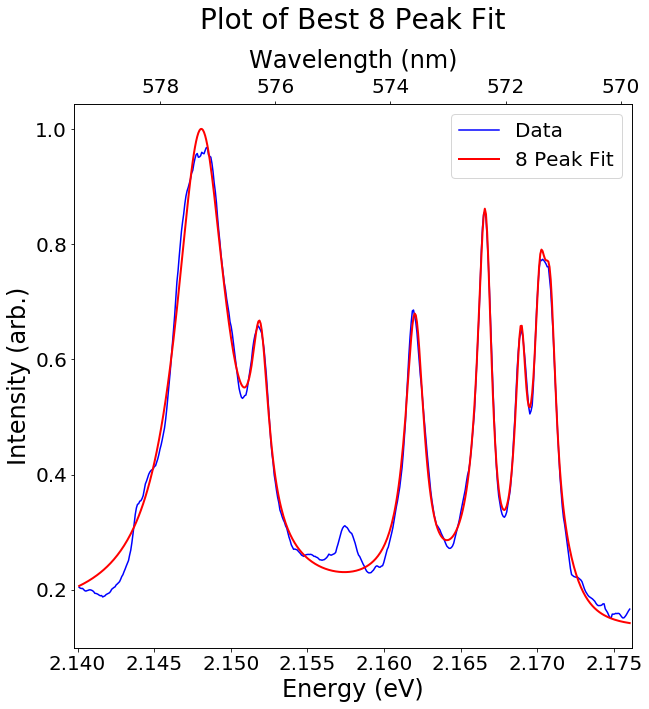

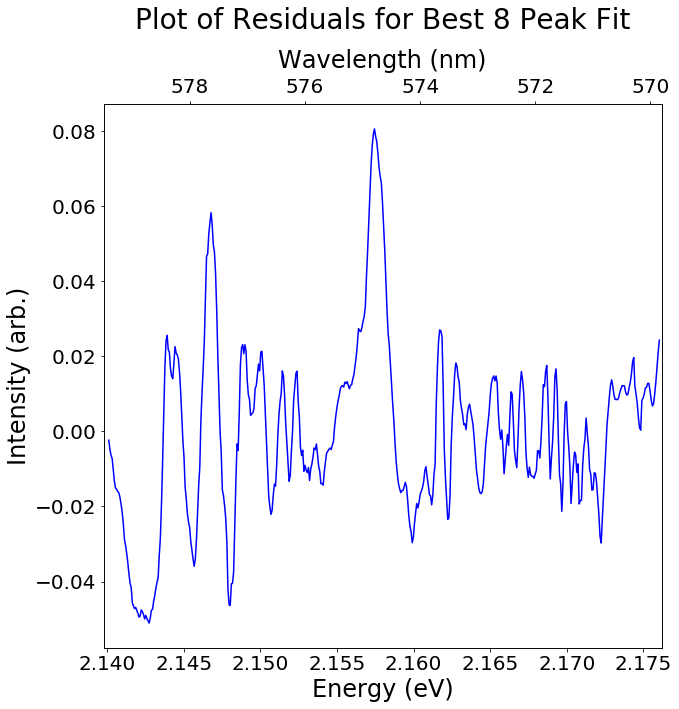

In [14]:
### DO NOT EDIT THIS CELL, BUT DO LOOK AT THE OUTPUT ###

# Once you have run your actual Bayesian analysis, you can look
# at this cell to evaluate the goodness of the fit

plot_best_fits()

In [15]:
### DO NOT EDIT THIS CELL, BUT DO LOOK AT THE OUTPUT ###

# This cell will list all fit parameters for each model, allowing

list_params()

6 Peak Model
----------------------------------------------------------

Eg: 2.1727 +/- 9.3e-05
Ry: 0.0901 +/- 0.002041
Offset: 0.146 +/- 0.002913
E1sg: 2.1519 +/- 2.1e-05
FWHM 1sg: 0.3728 +/- 0.018222
q 1sg: 0.0043 +/- 0.004239
Height 1sg: 0.0587 +/- 0.002528
Q. Def. 1: 0.0891 +/- 0.020282
FWHM 1: 1.1085 +/- 0.014293
q 1: 0.00049 +/- 0.0004773
Height 1: 0.4607 +/- 0.005859
Q. Def. 2: 0.0947 +/- 0.028783
FWHM 2: 0.3991 +/- 0.011962
q 2: 0.0629 +/- 0.01216
Height 2: 0.0938 +/- 0.002385
Q. Def. 3: 0.1464 +/- 0.040126
FWHM 3: 0.3068 +/- 0.007864
q 3: 0.1396 +/- 0.009506
Height 3: 0.0982 +/- 0.002274
Q. Def. 4: 0.1157 +/- 0.063081
FWHM 4: 0.2524 +/- 0.015324
q 4: 0.06 +/- 0.020499
Height 4: 0.0498 +/- 0.003437
Q. Def. 5: 0.1294 +/- 0.07307
FWHM 5: 0.1986 +/- 0.051427
q 5: 0.0129 +/- 0.011154
Height 5: 0.0252 +/- 0.013639
Q. Def. 6: 0.29 +/- 0.097513
FWHM 6: 0.39 +/- 0.027481
q 6: 0.0182 +/- 0.010964
Height 6: 0.1052 +/- 0.014816


7 Peak Model
----------------------------------------------

In [16]:
### EDIT THIS CELL ###

# Here we need to save the output of our Bayesian analysis.
# direc_save will be the directory into which you want to
# save your data. fn_save will be the file name.

direc_save = "C:\\Users\\pcadm\\Documents\\QNP Code\\QNP Code - Copy\\Saved Variables\\Stephan Transparent Sample Bayesian Analysis"

fn_save = '8-16-22 5 K Analysis, 5-7 peak models, 500000 iterations'

### STOP EDITING HERE, BUT READ INSTRUCTIONS BELOW ###

# For convenience, all data will be saved in one list variable with
# 10 entries. The information below relates the indices of this list
# to the information stored at each one.
#
# 0: bayesian_x, the x values of the data analyzed.
#
# 1: bayesian_y, the y values of the data analyzed.
#
# 2: num_iters, the number of iterations used when running the
#    Bayesian inference algorithm.
#
# 3: theta_info, the dictionary which maps the number of peaks being
#    tested to the list of fit parameters across all iterations and
#    replicas.
#
# 4: P_D_theta_info, the dictionary which maps the number of peaks
#    being tested to the list of "probabilities" for each sampled
#    parameter set for each iteration and replica.]
#
# 5: noise_sig_arr, the list of background noise standard deviation
#    values for each replica being tested.
#
# 6: F_arrs, the dictionary which maps the number of peaks being
#    tested to the list of F values for each replica.
#
# 7: F_indices, the dictionary mapping the number of peaks being
#    tested to the index of the lowest F value for each model.
#
# 8: param_means, the dictionary mapping the number of peaks being
#    tested to the average fit parameter values, based on the 
#    Bayesian Analysis.
#
# 9: param_stds, the dictionary mapping the number of peaks being
#    tested to the standard deviation of each parameter value,
#    based on the Bayesian analysis.

pickle_list = [bayesian_x, bayesian_y, num_iters, theta_info,
               P_D_theta_info, noise_sig_arr, F_arrs, F_indices,
               param_means, param_stds]

save_path = direc_save + '\\' + fn_save + '.pkl'


if not test_flag:
    with open(save_path, 'wb') as file:
        pickle.dump(pickle_list, file)

### At this point, if you feel confident that everything is working properly, you can set your number of iterations to a high number (probably at least 10,000), change the value of test_flag to False, and then rerun all cells to run your actual Bayesian inference.